In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.utils import shuffle

warnings.filterwarnings("ignore")

C:\Users\haeun\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [59]:
df = pd.read_csv("uci-secom.csv")

In [60]:
df

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1562,2008-10-16 15:13:00,2899.41,2464.36,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3424,...,203.1720,0.4988,0.0143,0.0039,2.8669,0.0068,0.0138,0.0047,203.1720,-1
1563,2008-10-16 20:49:00,3052.31,2522.55,2198.5667,1124.6595,0.8763,100.0,98.4689,0.1205,1.4333,...,NaN,0.4975,0.0131,0.0036,2.6238,0.0068,0.0138,0.0047,203.1720,-1
1564,2008-10-17 05:26:00,2978.81,2379.78,2206.3000,1110.4967,0.8236,100.0,99.4122,0.1208,NaN,...,43.5231,0.4987,0.0153,0.0041,3.0590,0.0197,0.0086,0.0025,43.5231,-1
1565,2008-10-17 06:01:00,2894.92,2532.01,2177.0333,1183.7287,1.5726,100.0,98.7978,0.1213,1.4622,...,93.4941,0.5004,0.0178,0.0038,3.5662,0.0262,0.0245,0.0075,93.4941,-1


In [61]:
df.drop(['Time'],axis=1, inplace=True)

In [62]:
df_statistic = df.describe().transpose()
df_2 = df.drop(df_statistic[df_statistic['std'] == 0].index, axis=1)

df_statistic_2 = df_2.describe().transpose()
df_3 = df.drop(df_statistic_2[(df_statistic_2['std'] > 0) & (df_statistic_2['std'] < 0.005)].index, axis=1)

In [63]:
for i in df_3.columns:
    if df_3[i].isna().sum()*100/len(df_3) > 50 :
        df_3.drop([i],axis=1,inplace=True)
    else:
        pass

In [64]:
df_3=df_3.fillna(0)

In [65]:
correlation_matrix = df_3.corr()

column_df=pd.DataFrame(columns=df_3.columns[:528])
for i in correlation_matrix.columns[:528]:
   column_df.loc[0,i]=(correlation_matrix[i]>=0.5).sum()

for i in correlation_matrix.columns[:528]:
  if column_df.loc[0,i]>3:
    df_3 = df_3.drop([i], axis=1)

In [66]:
df_4_pass = df_3[df_3['Pass/Fail'] == -1].copy()
df_4_fail = df_3[df_3['Pass/Fail'] == 1].copy()

In [67]:
def outlier_change(df, weight_val, over15_li):

  for i in range(len(df.columns[:-1])):

    a = df[list(df.columns)[i]]
    weight = weight_val
    quantile_25 = np.percentile(a.values, 25)
    quantile_75 = np.percentile(a.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = list(a[a>highest_val].index) + list(a[a<lowest_val].index)
    lowest_index = list(a[(a<lowest_val)].index)
    highest_index = list(a[(a>highest_val)].index)

    if(len(outlier_index) != 0) :

      if(len(outlier_index) >= len(df)*0.10):
          over15_li.append(list(df.columns)[i])
          over15_li.append(len(outlier_index))

      else:
        for index in range(0, len(lowest_index)):
          df.loc[[lowest_index[index]],[list(df.columns)[i]]] = lowest_val

        for index in range(0, len(highest_index)):
          df.loc[[ highest_index[index]],[list(df.columns)[i]]] =  highest_val

In [68]:
over15percent_result = []
outlier_change(df_4_pass,2.0,over15percent_result)
over15percent_result

['31',
 340,
 '40',
 245,
 '41',
 150,
 '116',
 176,
 '177',
 206,
 '251',
 175,
 '312',
 214,
 '389',
 168,
 '448',
 206,
 '523',
 173]

In [69]:
def namestr(obj, namespace):
    get_name=[name for name in namespace if namespace[name] is obj]
    return get_name[0]

def Change(a1):
    return namestr(a1, globals())

def importance_scatter_plot(data1, data2, Num, lank):
    normal_data = data1.copy()
    defective_data = data2.copy()

    importance = []

    columns = data1.columns

    for i, col1 in enumerate(columns):
        for j, col2 in enumerate(columns):
            if i >= j:
                continue

            normal_group = normal_data[[col1, col2]].values
            defective_group = defective_data[[col1, col2]].values

            section_size = (data1[col1].max() - data1[col1].min()) / Num

            normal_mean_list = []
            defective_mean_list = []
            normal_std_list = []
            defective_std_list = []

            for k in range(Num):
                section_min = data1[col1].min() + k * section_size
                section_max = section_min + section_size

                normal_section = normal_group[(normal_group[:,0] >= section_min) & (normal_group[:,0] < section_max)]
                defective_section = defective_group[(defective_group[:,0] >= section_min) & (defective_group[:,0] < section_max)]

                if len(normal_section) == 0 or len(defective_section) == 0:
                    continue

                normal_mean = np.mean(normal_section, axis=0, keepdims=True)
                defective_mean = np.mean(defective_section, axis=0, keepdims=True)
                normal_std = np.std(normal_section, axis=0, keepdims=True)
                defective_std = np.std(defective_section, axis=0, keepdims=True)

                if (normal_std == 0).any() or (defective_std == 0).any():
                    continue

                normal_mean_list.append(normal_mean)
                defective_mean_list.append(defective_mean)
                normal_std_list.append(normal_std)
                defective_std_list.append(defective_std)

            if len(normal_mean_list) > 0 and len(defective_mean_list) > 0:
                normal_mean_array = np.concatenate(normal_mean_list, axis=0)
                defective_mean_array = np.concatenate(defective_mean_list, axis=0)
                normal_std_array = np.concatenate(normal_std_list, axis=0)
                defective_std_array = np.concatenate(defective_std_list, axis=0)

                mahalanobis_diff = np.sqrt(np.sum(np.square(normal_mean_array - defective_mean_array) / ((normal_std_array**2 + defective_std_array**2)/4), axis=1))
                importance.append((col1, col2, np.mean(mahalanobis_diff)))

    importance_sorted = sorted(importance, key=lambda x: x[2], reverse=True)
    threshold_index = lank
    threshold = importance_sorted[threshold_index][2]

    important_vars = [(t[0], t[1]) for t in importance_sorted[:lank]]
    important_vars = list(set(important_vars))

    return important_vars

In [13]:
scatter=importance_scatter_plot(df_4_pass, df_4_fail, 10, 10)

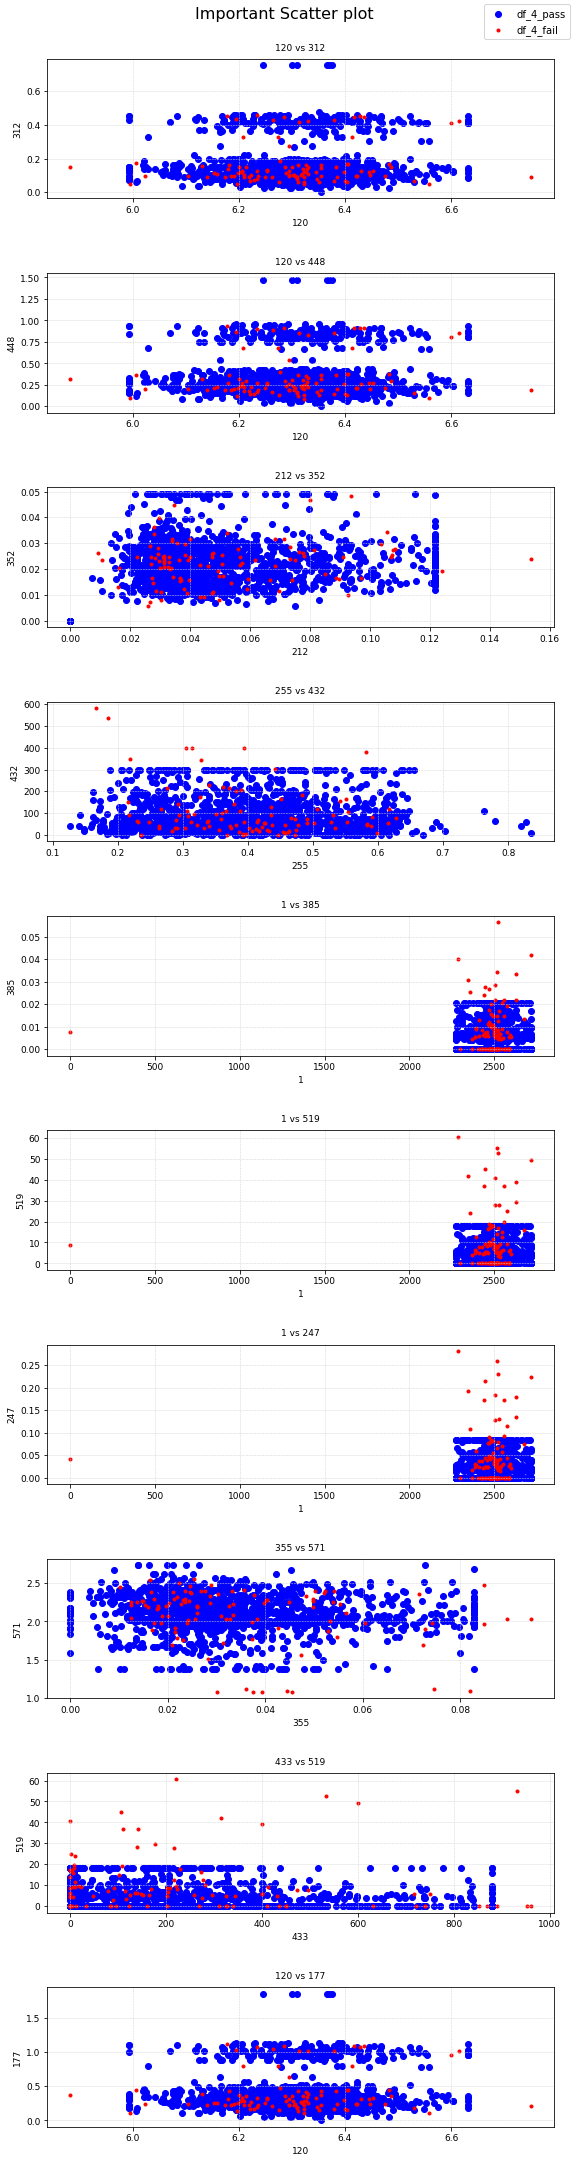

In [14]:
fig, axs = plt.subplots(10, 1, figsize=(8, 30))

for i, (col1, col2) in enumerate(scatter):
    axs[i].scatter(df_4_pass[col1], df_4_pass[col2], color='blue', label='Normal')
    axs[i].scatter(df_4_fail[col1], df_4_fail[col2], color='red', marker='.', label='Defective')
    axs[i].set_xlabel(col1, fontsize=9)
    axs[i].set_ylabel(col2, fontsize=9)
    axs[i].tick_params(axis='both', which='major', labelsize=9)
    axs[i].set_title(f'{col1} vs {col2}', fontsize=9, y=1.02)
    axs[i].grid(color='lightgray', linestyle='--', linewidth=0.5)

fig.legend(labels=[Change(df_4_pass), Change(df_4_fail)], loc='upper right')
fig.suptitle('Important Scatter plot', fontsize=16, y=1.0)
fig.tight_layout(h_pad=3, w_pad=8)
plt.show()

In [70]:
df_4_fail

,0,1,3,8,9,10,13,14,19,20,...,559,561,570,571,583,585,586,587,589,Pass/Fail
2,2932.61,2559.94,1698.0172,1.4436,0.0041,0.0013,0.0,9.5157,12.5404,1.4123,...,0.3718,24.7524,535.0245,2.0293,0.0157,3.1745,0.0584,0.0484,82.8602,1
10,2994.05,2548.21,1046.1468,1.5144,-0.0190,0.0013,0.0,11.8566,12.4663,1.4195,...,0.7213,53.1570,532.1764,1.8715,0.0158,3.2115,0.0355,0.0205,57.8122,1
11,2928.84,2479.40,1605.7578,1.4690,0.0170,-0.0154,0.0,9.1084,12.5263,1.4210,...,0.4385,42.3877,533.7464,2.1865,0.0427,8.5646,0.0370,0.0279,75.5077,1
14,2963.97,2629.48,947.7739,1.4474,0.0144,-0.0119,0.0,9.7561,12.4582,1.4029,...,0.1233,13.4909,532.6446,2.2808,0.0094,1.8483,0.0202,0.0289,142.9080,1
23,2884.74,2514.54,899.9488,1.5585,-0.0317,-0.0138,0.0,11.6229,12.4761,1.4290,...,0.1567,16.2531,536.0054,1.9902,0.0099,1.9771,0.0098,0.0213,216.8869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2988.39,2493.72,982.5452,1.5279,-0.0094,0.0001,0.0,9.7716,12.4276,1.3931,...,0.0868,9.3586,530.0846,1.9812,0.0154,3.0992,-0.0006,0.0118,0.0000,1
1400,3052.98,2515.51,969.3436,1.4065,-0.0037,-0.0058,0.0,10.2017,12.5276,1.3923,...,0.6421,55.8949,533.1809,1.0744,0.0158,3.1106,0.0302,0.0159,52.7014,1
1438,2951.84,2477.13,1435.9611,1.4613,-0.0027,-0.0039,0.0,11.1558,12.6241,1.4189,...,0.4864,51.6664,531.7464,2.2909,0.0118,2.3773,0.0178,0.0120,67.7994,1
1443,3173.18,2428.64,1556.3930,1.6073,-0.0278,-0.0057,0.0,9.1785,12.5788,1.3878,...,0.1537,16.2835,533.1364,2.0133,0.0192,3.8289,0.0281,0.0247,88.1528,1


In [71]:
fail_df = df_4_fail.drop('Pass/Fail', axis=1)

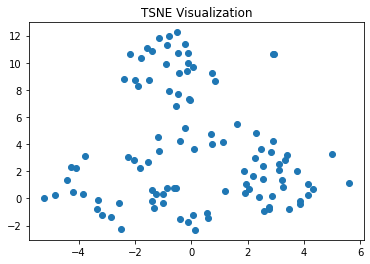

In [72]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(fail_df)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1])
plt.title('TSNE Visualization')
plt.show()

In [73]:
fail_tsne = pd.DataFrame(X_embedded, columns=['1','2'],index=fail_df.index)

In [74]:
fail_tsne

,1,2
2,2.491852,3.636564
10,-0.986220,0.331687
11,4.147365,0.226062
14,-0.861605,0.793545
23,-1.404268,0.599652
...,...,...
1365,-1.807644,2.207781
1400,-1.149775,11.861635
1438,4.315222,0.719509
1443,5.002746,3.266576


In [76]:
from sklearn.cluster import DBSCAN
from itertools import combinations

dbscan = DBSCAN(eps=1.5, min_samples=3)

dbscan.fit(fail_tsne)

labels = dbscan.labels_

unique_values, counts = np.unique(labels, return_counts=True)
print("Unique values:", unique_values)
print("Counts:", counts)

Unique values: [-1  0  1  2]
Counts: [ 3 45 29 27]


In [77]:
fail_tsne['cluster'] = labels

cluster_dfs = []
for cluster in np.unique(labels):
    cluster_df = fail_tsne[fail_tsne['cluster'] == cluster]
    cluster_dfs.append(cluster_df)

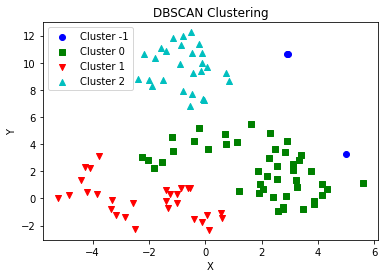

In [78]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # 군집별 색상
markers = ['o', 's', 'v', '^', 'D', 'x', '*']  # 군집별 마커

for i, cluster_df in enumerate(cluster_dfs):
    cluster_label = cluster_df['cluster'].iloc[0]
    color = colors[i % len(colors)]
    marker = markers[i % len(markers)]
    plt.scatter(cluster_df['1'], cluster_df['2'], c=color, marker=marker, label=f'Cluster {cluster_label}')

plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [79]:
fail_tsne

,1,2,cluster
2,2.491852,3.636564,0
10,-0.986220,0.331687,1
11,4.147365,0.226062,0
14,-0.861605,0.793545,1
23,-1.404268,0.599652,1
...,...,...,...
1365,-1.807644,2.207781,0
1400,-1.149775,11.861635,2
1438,4.315222,0.719509,0
1443,5.002746,3.266576,-1


In [80]:
df_4_fail['Pass/Fail'] = fail_tsne['cluster']

In [81]:
df_4_fail['Pass/Fail'].value_counts()

 0    45
 1    29
 2    27
-1     3
Name: Pass/Fail, dtype: int64

In [82]:
df_4_fail = df_4_fail[df_4_fail['Pass/Fail'] != -1]

In [83]:
final_df = pd.concat([df_4_fail,df_4_pass], axis=0)

In [84]:
class_mapping = {-1: 0, 0: 1, 1: 2, 2: 3}
final_df['Pass/Fail'] = final_df['Pass/Fail'].replace(class_mapping)

In [85]:
x_data = final_df.drop(['Pass/Fail'], axis=1)
y_data = final_df['Pass/Fail']

Supervisory Learning

In [86]:
k = 5
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=10)

accuracy_scores = []
f1_micro_scores = []
f1_macro_scores = []
f1_weighted_scores = []

for train_index, val_index in kf.split(x_data, y_data):
    X_train, X_val = x_data.iloc[train_index], x_data.iloc[val_index]
    y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

    smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
    X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

    model = XGBClassifier()
    model.fit(X_train_over, y_train_over)
    y_pred = model.predict(X_val)

    f1_micro = f1_score(y_val, y_pred, average='micro')
    f1_micro_scores.append(f1_micro)

print('best f1 micro score:', max(f1_micro_scores))

[18:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

Active Learning

In [109]:
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.3, stratify = y_data, random_state=42)

smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1094, 315) (1094,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (4092, 315) (4092,)
SMOTE 적용 후 레이블 값 분포:
 0    1023
3    1023
1    1023
2    1023
Name: Pass/Fail, dtype: int64


In [110]:
initial_idx = np.random.choice(range(len(X_train_over)), size=100, replace=False)
x_labeled = X_train_over.iloc[initial_idx]
y_labeled = y_train_over.iloc[initial_idx]

x_unlabeled = X_train_over.drop(X_train_over.index[initial_idx])
y_unlabeled = y_train_over.drop(y_train_over.index[initial_idx])

base_model = XGBClassifier()
base_model.fit(x_labeled, y_labeled)

[21:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [106]:
def select_uncertain_samples(model, unlabeled_data, n_samples):
    y_prob = model.predict_proba(unlabeled_data)
    entropy = -np.sum(y_prob * np.log2(y_prob), axis=1)
    uncertain_indices = np.argsort(entropy)[-n_samples:]

    return uncertain_indices

In [107]:
def select_uncertain_samples_bayesian(model, x_unlabeled, n_samples, n_mc_samples=100):
    x_unlabeled = shuffle(x_unlabeled)  
    uncertain_scores = np.zeros(len(x_unlabeled))

    for _ in range(n_mc_samples):
        y_prob = model.predict_proba(x_unlabeled)
        uncertain_scores += -np.sum(y_prob * np.log2(y_prob), axis=1)

    uncertain_scores /= n_mc_samples 

    uncertain_indices = np.argsort(uncertain_scores)[-n_samples:]

    return uncertain_indices

In [108]:
f1_score_history=[]
for step in range(500):
    confused_indices = select_uncertain_samples(model, x_unlabeled, 10)

    x_confused = x_unlabeled.iloc[confused_indices]
    y_confused = y_unlabeled.iloc[confused_indices]

    x_unlabeled = x_unlabeled.drop(x_unlabeled.index[confused_indices])
    y_unlabeled = y_unlabeled.drop(y_unlabeled.index[confused_indices])

    x_labeled = np.concatenate([x_labeled, x_confused])
    y_labeled = np.concatenate([y_labeled, y_confused])

    model = XGBClassifier()
    model.fit(x_labeled, y_labeled)

    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='micro')
    f1_score_history.append(f1)

    steps = step + 1

    print("Step", step + 1)
    print('label:', x_labeled.shape)
    print('unlabel:', x_unlabeled.shape)
    print(y_confused.value_counts().reset_index().rename(columns={'index': 'Label', 'Pass/Fail': 'Added Count'}))
    print("F1 Score:", f1)
    print()

    if f1 > 0.94:
        break

f1_score_history

[21:54:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 1
label: (110, 315)
unlabel: (3982, 315)
   Label  Added Count
0      0            5
1      1            3
2      3            2
F1 Score: 0.6446808510638298

[21:54:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 2
label: (120, 315)
unlabel: (3972, 315)
   Label  Added Count
0      3            6
1      1            2
2      0            2
F1 Score: 0.6085106382978723

[21:54:40] WARNING: C:/Users/Administrator/workspa

Step 18
label: (280, 315)
unlabel: (3812, 315)
   Label  Added Count
0      0            5
1      2            3
2      1            2
F1 Score: 0.9212765957446809

[21:54:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 19
label: (290, 315)
unlabel: (3802, 315)
   Label  Added Count
0      0            6
1      2            4
F1 Score: 0.925531914893617

[21:54:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 20
label: (300, 315)
unlabel: (3792, 315)
   Label  Added Count
0 

Step 36
label: (460, 315)
unlabel: (3632, 315)
   Label  Added Count
0      0            5
1      3            3
2      1            2
F1 Score: 0.9276595744680851

[21:55:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 37
label: (470, 315)
unlabel: (3622, 315)
   Label  Added Count
0      0           10
F1 Score: 0.9446808510638298



[0.6446808510638298,
 0.6085106382978723,
 0.6574468085106383,
 0.6468085106382979,
 0.6638297872340425,
 0.6404255319148936,
 0.6702127659574468,
 0.6936170212765957,
 0.6978723404255319,
 0.725531914893617,
 0.7170212765957447,
 0.7404255319148936,
 0.7957446808510639,
 0.8361702127659575,
 0.8404255319148938,
 0.8723404255319149,
 0.8851063829787233,
 0.9212765957446809,
 0.925531914893617,
 0.902127659574468,
 0.9,
 0.9191489361702128,
 0.9127659574468086,
 0.9127659574468086,
 0.9085106382978724,
 0.9148936170212766,
 0.9276595744680851,
 0.9382978723404255,
 0.9340425531914893,
 0.9276595744680851,
 0.9340425531914893,
 0.9297872340425531,
 0.9319148936170213,
 0.9340425531914893,
 0.9340425531914893,
 0.9276595744680851,
 0.9446808510638298]

In [111]:
f1_score_history_b = []
steps = 0
    
for step in range(500):
    confused_indices = select_uncertain_samples_bayesian(model, x_unlabeled, 10)

    x_confused = x_unlabeled.iloc[confused_indices]
    y_confused = y_unlabeled.iloc[confused_indices]

    x_unlabeled = x_unlabeled.drop(x_unlabeled.index[confused_indices])
    y_unlabeled = y_unlabeled.drop(y_unlabeled.index[confused_indices])

    x_labeled = np.concatenate([x_labeled, x_confused])
    y_labeled = np.concatenate([y_labeled, y_confused])

    model = XGBClassifier()
    model.fit(x_labeled, y_labeled)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='micro')
    f1_score_history_b.append(f1)

    steps = step+1

    print("Step", step+1)
    print('label :',x_labeled.shape)
    print('unlabel :',x_unlabeled.shape)
    print(y_confused.value_counts().reset_index().rename(columns={'index': 'Label', 'Pass/Fail': 'Added Count'}))
    print("F1 Score:", f1)
    print()

    if f1 > 0.94 :
        break
f1_score_history_b

[21:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 1
label : (110, 315)
unlabel : (3982, 315)
   Label  Added Count
0      3            4
1      2            3
2      0            2
3      1            1
F1 Score: 0.723404255319149

[21:55:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 2
label : (120, 315)
unlabel : (3972, 315)
   Label  Added Count
0      3            3
1      0            3
2      2            2
3      1            2
F1 Score: 0.7425531914893617

[21

[21:57:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 18
label : (280, 315)
unlabel : (3812, 315)
   Label  Added Count
0      3            3
1      0            3
2      1            3
3      2            1
F1 Score: 0.7702127659574468

[21:57:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 19
label : (290, 315)
unlabel : (3802, 315)
   Label  Added Count
0      3            5
1      0            3
2      1            2
F1 Score: 0.7617021276595745

[21:57:33] WARNING: C:

Step 34
label : (440, 315)
unlabel : (3652, 315)
   Label  Added Count
0      1            3
1      0            3
2      2            2
3      3            2
F1 Score: 0.8340425531914893

[21:58:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 35
label : (450, 315)
unlabel : (3642, 315)
   Label  Added Count
0      2            4
1      1            3
2      3            3
F1 Score: 0.8319148936170212

[21:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 36
label : (460, 

Step 51
label : (610, 315)
unlabel : (3482, 315)
   Label  Added Count
0      3            4
1      1            3
2      0            2
3      2            1
F1 Score: 0.8468085106382979

[22:00:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 52
label : (620, 315)
unlabel : (3472, 315)
   Label  Added Count
0      2            5
1      1            2
2      3            2
3      0            1
F1 Score: 0.8468085106382979

[22:00:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Step 68
label : (780, 315)
unlabel : (3312, 315)
   Label  Added Count
0      1            5
1      0            3
2      2            1
3      3            1
F1 Score: 0.8765957446808512

[22:02:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 69
label : (790, 315)
unlabel : (3302, 315)
   Label  Added Count
0      2            4
1      1            3
2      0            2
3      3            1
F1 Score: 0.8638297872340426

[22:02:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Step 85
label : (950, 315)
unlabel : (3142, 315)
   Label  Added Count
0      0            5
1      2            2
2      1            2
3      3            1
F1 Score: 0.9063829787234041

[22:04:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 86
label : (960, 315)
unlabel : (3132, 315)
   Label  Added Count
0      0            5
1      2            2
2      1            2
3      3            1
F1 Score: 0.8914893617021277

[22:04:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Step 102
label : (1120, 315)
unlabel : (2972, 315)
   Label  Added Count
0      2            3
1      3            3
2      0            3
3      1            1
F1 Score: 0.9191489361702128

[22:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 103
label : (1130, 315)
unlabel : (2962, 315)
   Label  Added Count
0      0            5
1      2            2
2      1            2
3      3            1
F1 Score: 0.9106382978723404

[22:06:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavi

Step 119
label : (1290, 315)
unlabel : (2802, 315)
   Label  Added Count
0      2            5
1      1            3
2      0            2
F1 Score: 0.925531914893617

[22:08:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 120
label : (1300, 315)
unlabel : (2792, 315)
   Label  Added Count
0      0            4
1      3            3
2      2            2
3      1            1
F1 Score: 0.925531914893617

[22:08:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 121
label : (13

Step 136
label : (1460, 315)
unlabel : (2632, 315)
   Label  Added Count
0      3            4
1      2            3
2      1            3
F1 Score: 0.925531914893617

[22:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 137
label : (1470, 315)
unlabel : (2622, 315)
   Label  Added Count
0      2            4
1      0            3
2      1            2
3      3            1
F1 Score: 0.925531914893617

[22:10:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 138
label : (14

Step 153
label : (1630, 315)
unlabel : (2462, 315)
   Label  Added Count
0      2            5
1      3            3
2      1            1
3      0            1
F1 Score: 0.9276595744680851

[22:12:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 154
label : (1640, 315)
unlabel : (2452, 315)
   Label  Added Count
0      0            4
1      3            3
2      1            2
3      2            1
F1 Score: 0.9319148936170213

[22:13:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavi

Step 170
label : (1800, 315)
unlabel : (2292, 315)
   Label  Added Count
0      3            4
1      1            3
2      0            2
3      2            1
F1 Score: 0.9404255319148935



[0.723404255319149,
 0.7425531914893617,
 0.676595744680851,
 0.7085106382978722,
 0.7021276595744681,
 0.6617021276595745,
 0.6829787234042554,
 0.6957446808510638,
 0.7063829787234043,
 0.7170212765957447,
 0.7021276595744681,
 0.723404255319149,
 0.7063829787234043,
 0.7382978723404255,
 0.7276595744680852,
 0.746808510638298,
 0.746808510638298,
 0.7702127659574468,
 0.7617021276595745,
 0.8021276595744681,
 0.7957446808510639,
 0.776595744680851,
 0.8000000000000002,
 0.8063829787234043,
 0.7936170212765957,
 0.8000000000000002,
 0.8106382978723404,
 0.8148936170212766,
 0.8212765957446808,
 0.8319148936170212,
 0.8212765957446808,
 0.8297872340425532,
 0.8446808510638298,
 0.8340425531914893,
 0.8319148936170212,
 0.8191489361702128,
 0.8425531914893616,
 0.825531914893617,
 0.8276595744680851,
 0.8468085106382979,
 0.8319148936170212,
 0.8468085106382979,
 0.8404255319148938,
 0.8340425531914893,
 0.825531914893617,
 0.8617021276595744,
 0.8446808510638298,
 0.8574468085106381,


510개의 선별된 라벨이 2000개의 라벨링 성능과 동일하다

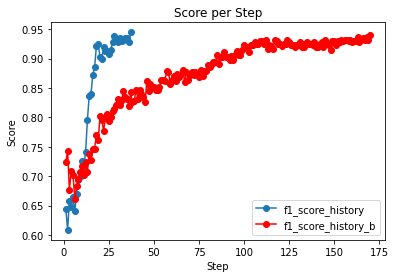

In [116]:
plt.plot(range(1,38), f1_score_history, marker='o', label='f1_score_history')
plt.plot(range(1,171), f1_score_history_b, marker='o', label='f1_score_history_b',color='red')
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Score per Step')
plt.legend()
plt.show()

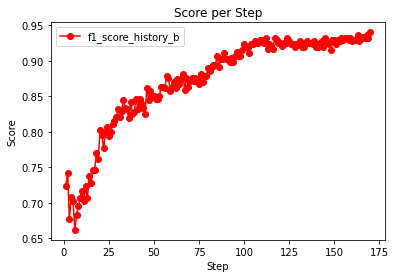

In [118]:
plt.plot(range(1,171), f1_score_history_b, marker='o', label='f1_score_history_b',color='red')
plt.xlabel('Step')
plt.ylabel('Score')
plt.title('Score per Step')
plt.legend()
plt.show()

만약 새로운 불량군이 등장했다면? 새로운 불량군 : 3

In [77]:
X_train, X_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.3, stratify = y_data, random_state=42)

smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train_over,y_train_over = smote.fit_resample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1094, 315) (1094,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (4096, 315) (4096,)
SMOTE 적용 후 레이블 값 분포:
 0    1024
3    1024
2    1024
1    1024
Name: Pass/Fail, dtype: int64


In [78]:
#초기 데이터를 0,1,2로만 구성

labeling_idx = np.where(np.isin(y_train_over, [0, 1, 2]))[0]
initial_idx = np.random.choice(labeling_idx, size=1000, replace=False)
x_labeled = X_train_over.iloc[initial_idx]
y_labeled = y_train_over.iloc[initial_idx]

x_unlabeled = X_train_over.drop(X_train_over.index[initial_idx])
y_unlabeled = y_train_over.drop(y_train_over.index[initial_idx])

model = XGBClassifier()
model.fit(x_labeled, y_labeled)

[14:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

라벨 3을 빠르게 감지해서 학습한다!

In [79]:
f1_score_history = []

steps = 0

for step in range(500):
    confused_indices = select_uncertain_samples_bayesian(model, x_unlabeled, 10)

    x_confused = x_unlabeled.iloc[confused_indices]
    y_confused = y_unlabeled.iloc[confused_indices]

    x_unlabeled = x_unlabeled.drop(x_unlabeled.index[confused_indices])
    y_unlabeled = y_unlabeled.drop(y_unlabeled.index[confused_indices])

    x_labeled = np.concatenate([x_labeled, x_confused])
    y_labeled = np.concatenate([y_labeled, y_confused])

    model = XGBClassifier()
    model.fit(x_labeled, y_labeled)

    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='micro')
    f1_score_history.append(f1)

    steps = step+1

    print("Step", step+1)
    print('label :',x_labeled.shape)
    print('unlabel :',x_unlabeled.shape)
    print(y_confused.value_counts().reset_index().rename(columns={'index': 'Label', 'Pass/Fail': 'Added Count'}))
    print("F1 Score:", f1)
    print()

    if f1 > 0.94 :
      break

[14:06:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 1
label : (1010, 315)
unlabel : (3086, 315)
   Label  Added Count
0      3            5
1      2            3
2      0            1
3      1            1
F1 Score: 0.927505330490405

[14:06:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 2
label : (1020, 315)
unlabel : (3076, 315)
   Label  Added Count
0      2            3
1      3            3
2      0            2
3      1            2
F1 Score: 0.9211087420042644

[

Step 17
label : (1170, 315)
unlabel : (2926, 315)
   Label  Added Count
0      2            5
1      1            4
2      0            1
F1 Score: 0.927505330490405

[14:08:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 18
label : (1180, 315)
unlabel : (2916, 315)
   Label  Added Count
0      3            5
1      1            2
2      0            2
3      2            1
F1 Score: 0.9253731343283582

[14:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 19
label : (1190

Step 34
label : (1340, 315)
unlabel : (2756, 315)
   Label  Added Count
0      3            4
1      1            2
2      0            2
3      2            2
F1 Score: 0.9360341151385928

[14:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Step 35
label : (1350, 315)
unlabel : (2746, 315)
   Label  Added Count
0      3            3
1      2            3
2      1            2
3      0            2
F1 Score: 0.9402985074626865

